# Introduction

Experimentation on the [UC2018 DualMyo Hand Gesture Dataset](https://zenodo.org/record/1320922#.Xi9l5xfgoWo).

In [1]:
import os
import sys
import requests
import pickle
import matplotlib.pyplot as plt
import numpy as np
import sequentia as seq
import sequentia.classifiers, sequentia.preprocessing
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

# Import utility function for displaying results
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import show_results

# Set seed for reproducible randomness
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed)

In [2]:
classes = [str(i) for i in range(8)]
classes

['0', '1', '2', '3', '4', '5', '6', '7']

In [3]:
X, y = [], []
url = 'https://zenodo.org/record/1320922/files/dualmyo_dataset.pkl'

try:
    file = 'dualmyo_dataset.pkl'
    print('Downloading dataset from {} ...'.format(url))
    response = requests.get(url)
    with open(file, 'wb') as f:
        print('Writing {} ...'.format(file))
        f.write(response.content)
except:
    raise
else:
    print('Unpickling data into Numpy arrays ...')
    data = pickle.load(open(file, 'rb'))
    X = data[0]
    y = [str(label) for label in data[1]]
    print('Done!')
finally:
    os.remove(file)

Writing dualmyo_dataset.pkl ...
Unpickling data into Numpy arrays ...
Done!


In [4]:
# Shuffle and split the data into training, validation and test sets (65-20-15)
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.35, shuffle=True, random_state=rng)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.43, shuffle=True, random_state=rng)

# Display the split sizes
print('Training set size: {}'.format(len(y_train)))
print('Validation set size: {}'.format(len(y_val)))
print('Test set size: {}'.format(len(y_test)))

Training set size: 572
Validation set size: 176
Test set size: 133


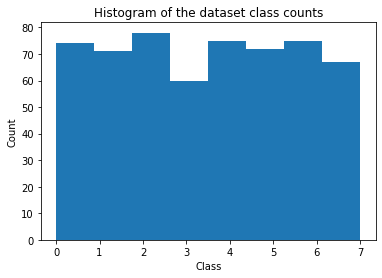

In [5]:
# Plot a histogram of the class counts in the training set
plt.title('Histogram of the dataset class counts')
plt.xlabel('Class')
plt.ylabel('Count')
plt.hist(sorted(y_train), bins=len(classes))
plt.show()

In [6]:
pre = seq.preprocessing.Preprocess()
# Downsample with averaging and a downsample factor of n=5
pre.downsample(n=5, method='average')
# Apply a mean filter with n=5
pre.filtrate(n=5, method='mean')
# Standardize the data
pre.center()
# Display a summary of the preprocessing transformations
pre.summary()

          Preprocessing summary:         
1. Downsampling:
   Averaging with downsample factor (n=5)
-----------------------------------------
2. Filtering:
   Mean filter with window size (n=5)
-----------------------------------------
3. Centering


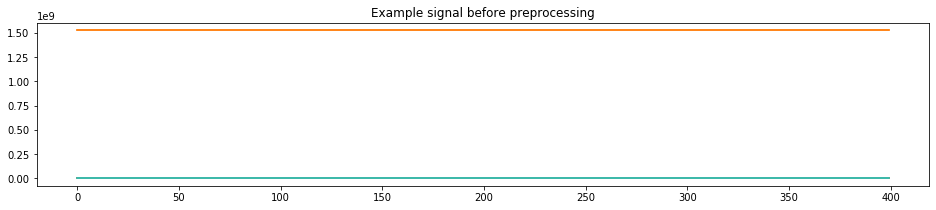

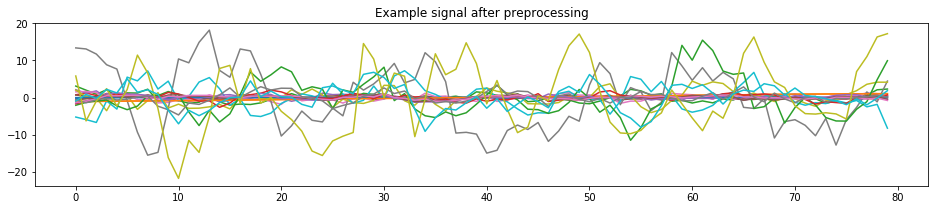

In [7]:
# Pick an example signal for visualization
x = X_train[1]

plt.figure(figsize=(16, 3))
plt.title('Example signal before preprocessing')
plt.plot(x)
plt.show()

plt.figure(figsize=(16, 3))
plt.title('Example signal after preprocessing')
plt.plot(pre.transform(x))
plt.show()

In [8]:
X_train, X_val, X_test = pre.transform(X_train), pre.transform(X_val), pre.transform(X_test)

## Hidden Markov Model classifier

### Fitting the model

In [9]:
%%time

# Create HMMs to represent each class
hmms = []
for c in tqdm(classes, desc='Training HMMs'):
    hmm = seq.classifiers.HMM(label=c, n_states=5, random_state=rng)
    hmm.set_random_initial()
    hmm.set_random_transitions()
    try:
        hmm.fit([X_train[i] for i, label in enumerate(y_train) if label == c])
    except:
        # NumPy sometimes raises some errors as a result of instability during the Cholesky decomposition.
        # According to issue #414 on Pomegranate's GitHub repository, this may be caused by:
        # - Too many states in the HMMs
        # - Too many dimensions in the input data, which leads to a large covariance matrix
        # - Too few training examples
        pass
    hmms.append(hmm)
    
# Fit a HMM classifier with the HMMs
clf = seq.classifiers.HMMClassifier()
clf.fit(hmms)


CPU times: user 48.2 s, sys: 410 ms, total: 48.6 s
Wall time: 52 s


### Evaluating the model

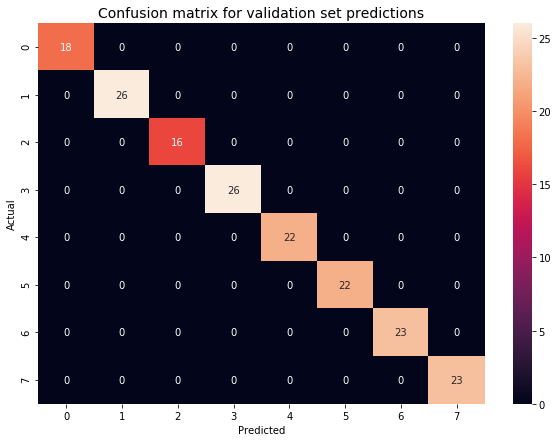

Accuracy: 100.00%
CPU times: user 732 ms, sys: 28.5 ms, total: 761 ms
Wall time: 845 ms


In [10]:
%%time
acc, cm = clf.evaluate(X_val, y_val, labels=classes)
show_results(acc, cm, dataset='validation', labels=classes)